In [4]:
# 참고: https://wikidocs.net/262586, https://wikidocs.net/262595
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv(override=True)

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH15-Agents")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH15-Agents


In [15]:
from langchain.tools import tool
from typing import List, Dict, Annotated
from langchain_teddynote.tools import GoogleNews
from langchain_experimental.utilities import PythonREPL


# 도구 생성
@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search Google News by input keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


# 도구 생성
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    result = ""
    try:
        result = PythonREPL().run(code)
    except BaseException as e:
        print(f"Failed to execute. Error: {repr(e)}")
    finally:
        return result


print(f"도구 이름: {search_news.name}")
print(f"도구 설명: {search_news.description}")
print(f"도구 이름: {python_repl_tool.name}")
print(f"도구 설명: {python_repl_tool.description}")


도구 이름: search_news
도구 설명: Search Google News by input keyword
도구 이름: python_repl_tool
도구 설명: Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user.


In [16]:
# tools 정의
tools = [search_news, python_repl_tool]

In [18]:
from langchain_core.prompts import ChatPromptTemplate

# 프롬프트 생성
# 프롬프트는 에이전트에게 모델이 수행할 작업을 설명하는 텍스트를 제공합니다. (도구의 이름과 역할을 입력)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. "
            "Make sure to use the `search_news` tool for searching keyword related news.",
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)


In [19]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_tool_calling_agent

# LLM 정의
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Agent 생성
agent = create_tool_calling_agent(llm, tools, prompt)

In [20]:
from langchain.agents import AgentExecutor

# AgentExecutor 생성
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    max_iterations=10,
    max_execution_time=10,
    handle_parsing_errors=True,
)

# AgentExecutor 실행
result = agent_executor.invoke({"input": "AI 투자와 관련된 뉴스를 검색해 주세요."})

print("Agent 실행 결과:")
print(result["output"])




> Entering new AgentExecutor chain...

Invoking: `search_news` with `{'query': 'AI 투자'}`


[{'url': 'https://news.google.com/rss/articles/CBMiX0FVX3lxTE5BM01hbENVMXVydWowNlFXNld1alN6bjNjaFZLOG9mcms5cnRlbjlPUTNyWEFKdFNPMGRWS3FUclBRelJ5V3ZVbzVZbF9xZVV6bzJaZGZ6V2JhanU5emlF?oc=5', 'content': "퓨리오사AI 투자 네이버…메타와 AI칩 매개 '공동전선' 길 열리나 - 뉴스1"}, {'url': 'https://news.google.com/rss/articles/CBMiVkFVX3lxTE1FNUdRT1BGTVBtb0MtSTlydmw2T2NqZ1lQWWpKOV9JRGtuUWNEdVNSV1d4eHpYVjdET2hOYW5XbzdSekhCMl9ELUFXTHlQSDRrenJjbzVn?oc=5', 'content': '美 빅테크, 아시아·중동에 AI 투자 확대…인재·인프라 늘려 - ZD넷 코리아'}, {'url': 'https://news.google.com/rss/articles/CBMiUkFVX3lxTE5ZeHIzX19DUVJQZl80SUdwZTVVUTRWc2cwNUVKbXVnSTRjWmp1WTVGVWhEV216MmlsNnh2dHhHY2FpNXJYQmVlNE1FcHRXLXhQZ0E?oc=5', 'content': '글로벌 전문가가 한국 주식 접은 이유는 ··· “AI·코인도 거품” - 매일경제'}, {'url': 'https://news.google.com/rss/articles/CBMigAFBVV95cUxPOUJuUmgtOVN3TW5UdFVSVWFYZkNqSzRUbENZb1ZWNkdFOHdxdzh4bXZyYjNlTm13dzJtWkJlVWlST2duNDFMRm5GOEVyNW9xYlNSdFlqcGRFTnc0Y1RPelhrQUh6aU40QW1uWkRNU

In [21]:
from langchain_teddynote.messages import AgentStreamParser

agent_stream_parser = AgentStreamParser()



> Entering new None chain...


Python REPL can execute arbitrary code. Use with caution.


[도구 호출]
Tool: python_repl_tool
code: import matplotlib.pyplot as plt

# 데이터
sizes = [15, 30, 45, 10]
labels = ['A', 'B', 'C', 'D']
colors = ['gold', 'lightcoral', 'lightskyblue', 'yellowgreen']

# 파이 차트 그리기
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sample Pie Chart')

# 차트 보여주기
plt.show()
Log: 
Invoking: `python_repl_tool` with `{'code': "import matplotlib.pyplot as plt\n\n# 데이터\nsizes = [15, 30, 45, 10]\nlabels = ['A', 'B', 'C', 'D']\ncolors = ['gold', 'lightcoral', 'lightskyblue', 'yellowgreen']\n\n# 파이 차트 그리기\nplt.figure(figsize=(8, 6))\nplt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)\nplt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.\nplt.title('Sample Pie Chart')\n\n# 차트 보여주기\nplt.show()"}`




Invoking: `python_repl_tool` with `{'code': "import matplotlib.pyplot as pl

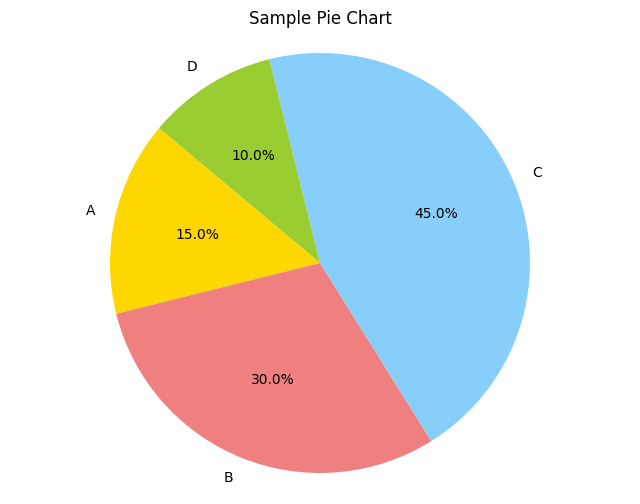

[관찰 내용]
Observation: 
파이 차트가 성공적으로 그려졌습니다. 차트에는 A, B, C, D의 네 가지 카테고리가 포함되어 있으며, 각 카테고리의 비율이 표시되어 있습니다. 차트의 제목은 "Sample Pie Chart"입니다. 

추가적으로 다른 차트를 그리거나 다른 데이터로 작업하고 싶으신가요?

> Finished chain.
[최종 답변]
파이 차트가 성공적으로 그려졌습니다. 차트에는 A, B, C, D의 네 가지 카테고리가 포함되어 있으며, 각 카테고리의 비율이 표시되어 있습니다. 차트의 제목은 "Sample Pie Chart"입니다. 

추가적으로 다른 차트를 그리거나 다른 데이터로 작업하고 싶으신가요?


In [22]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream(
    {"input": "matplotlib 을 사용하여 pie 차트를 그리는 코드를 작성하고 실행하세요."}
)

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    agent_stream_parser.process_agent_steps(step)